# Fairlib Interactive Tutorial
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HanXudong/fairlib/blob/main/tutorial/demo.ipynb)

# Welcome to the *fairlib* interactive tutorial

In this tutorial, we will:
- Show how to install *fairlib*, and prepare a preprocessed sentiment analysis dataset.
- Show how to train a model with or without debiasing.
- Show how to analyze the results, including creating tables and figures
- Show how to run experiments over customized datasets.

## 1. Installation

In [1]:
!pip install fairlib

     |████████████████████████████████| 62 kB 788 kB/s 
     |████████████████████████████████| 256 kB 10.6 MB/s 
     |████████████████████████████████| 4.0 MB 25.6 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
     |████████████████████████████████| 895 kB 66.3 MB/s 
     |████████████████████████████████| 6.6 MB 37.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import fairlib

## 2. Prepare Dataset

In this notebook, we will be using the Moji dataset, where each tweet is annotated with a binary sentiment label (happy verse sad) and a binary race label (AAE verse SAE).
Followings are random examples from the Moji dataset.

| Text | Sentiment | Race |
| ---- | --------- | ---- |
| Dfl somebody said to me yesterday that how can u u have a iPhone or an S3 an ur phone off dfl | Positive | AAE|
| smh I bet maybe u just don't care bout poor boo no more | Negative | AAE |
| I actually put jeans on today and I already wanna go put on leggings or yogas | Positive | SAE |
| I'm sitting next to the most awkward couple on the plane like they are making out and holding hands , I just can't | Negative | SAE |


For simplification, here we directly use the encoded Moji dataset provided by [Ravfogel et al. \(2020\)](https://github.com/shauli-ravfogel/nullspace_projection/blob/master/download_data.sh). Original tweets are encoded with the pre-trained [DeepMoji model](https://github.com/bfelbo/DeepMoji) as 2304d vectors and grouped by the target classes  and race labels . The following cell creates a `data` directory for saving the pre-processed data.

In [3]:
!mkdir -p data/deepmoji
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_pos.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_neg.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/neg_pos.npy' -P 'data/deepmoji'
!wget 'https://storage.googleapis.com/ai2i/nullspace/deepmoji/neg_neg.npy' -P 'data/deepmoji'

--2022-04-28 11:16:07--  https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_pos.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405494864 (387M) [application/octet-stream]
Saving to: ‘data/deepmoji/pos_pos.npy’

pos_pos.npy         100%[===================>] 386.71M  54.0MB/s    in 7.2s    

2022-04-28 11:16:14 (54.0 MB/s) - ‘data/deepmoji/pos_pos.npy’ saved [405494864/405494864]

--2022-04-28 11:16:14--  https://storage.googleapis.com/ai2i/nullspace/deepmoji/pos_neg.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405504080 (387M) [application

We split the dataset into the train, dev, and test sets.

In [4]:
import numpy as np
import os


def read_data_file(input_file: str):
    vecs = np.load(input_file)

    np.random.shuffle(vecs)

    return vecs[:40000], vecs[40000:42000], vecs[42000:44000]

In [5]:
in_dir = "data/deepmoji"
out_dir = "data/deepmoji"

os.makedirs(out_dir, exist_ok=True)

for split in ['pos_pos', 'pos_neg', 'neg_pos', 'neg_neg']:
    train, dev, test = read_data_file(in_dir + '/' + split + '.npy')
    for split_dir, data in zip(['train', 'dev', 'test'], [train, dev, test]):
        os.makedirs(out_dir + '/' + split_dir, exist_ok=True)
        np.save(out_dir + '/' + split_dir + '/' + split + '.npy', data)

## 3. Standard Usage

So far, we have installed the *fairlib* and prepared the dataset for training. 
Now let's take a look at an example of training a standard sentiment analysis model naively without debiasing. 

Before moving to the training, we first define a list of hyperparameters that will be repeatedly used in this tutorial.

In [6]:
Shared_options = {
    # The name of the dataset, corresponding dataloader will be used,
    "dataset":  "Moji",

    # Specifiy the path to the input data
    "data_dir": "data/deepmoji",

    # Device for computing, -1 is the cpu
    "device_id":    -1,

    # The default path for saving experimental results
    "results_dir":  r"results",

    # Will be used for saving experimental results
    "project_dir":  r"dev",

    # We will focusing on TPR GAP, implying the Equalized Odds for binary classification.
    "GAP_metric_name":  "TPR_GAP",

    # The overall performance will be measured as accuracy
    "Performance_metric_name":  "accuracy",

    # Model selections are based on DTO
    "selection_criterion":  "DTO",

    # Default dirs for saving checkpoints
    "checkpoint_dir":   "models",
    "checkpoint_name":  "checkpoint_epoch",

    # Loading experimental results
    "n_jobs":   1,
}

In [7]:
!rm -rf results

Without an explicitly specified debiasing approach, *fairlib* by default trains and evaluates a binary MLP classifier. As a result, we only need to define: 
1. Path to the dataset.
2. Dataset name, which will be used to initialize built-in dataloaders.
3. Experiment id, which is the identifier of the current experiment, and experimental results with respect to the same `exp_id` will be saved in the same dir.

In [8]:
args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"vanilla",
}

# Init the argument
options = fairlib.BaseOptions()
state = options.get_state(args=args, silence=True)

INFO:root:Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-525ea3e4-eabe-40ba-93be-e6b6a45add8f.json']
INFO:root:Logging to ./results/dev/Moji/vanilla/output.log


2022-04-28 11:16:51 [INFO ]  ======================================== 2022-04-28 11:16:51 ========================================
2022-04-28 11:16:51 [INFO ]  Base directory is ./results/dev/Moji/vanilla
Loaded data shapes: (99998, 2304), (99998,), (99998,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7998, 2304), (7998,), (7998,)


### Train a model without explicitly debiasing

Given the 2304d encoded text representations, the default model in *fairlib* is a 3-layer MLP classifier with Tanh activation functions in between. 

To customize the MLP architecture, we can specify the hyperparameters in the `state` as follows
```python
state.hidden_size = 300
state.n_hidden = 2
state.activation_function = "Tanh"
```

Please see the [model architecture section](https://github.com/HanXudong/fairlib/blob/main/docs/usage.md#basic-operation) for more details about the hyperparameters corresponding to the model architecture.

In [9]:
# Init Model
model = fairlib.networks.get_main_model(state)

2022-04-28 11:16:53 [INFO ]  MLP( 
2022-04-28 11:16:53 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-04-28 11:16:53 [INFO ]    (AF): Tanh()
2022-04-28 11:16:53 [INFO ]    (hidden_layers): ModuleList(
2022-04-28 11:16:53 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-04-28 11:16:53 [INFO ]      (1): Tanh()
2022-04-28 11:16:53 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-04-28 11:16:53 [INFO ]      (3): Tanh()
2022-04-28 11:16:53 [INFO ]    )
2022-04-28 11:16:53 [INFO ]    (criterion): CrossEntropyLoss()
2022-04-28 11:16:53 [INFO ]  )
2022-04-28 11:16:53 [INFO ]  Total number of parameters: 782402 



A list of hyperparameters has been predefined in *fairlib*, so we can now directly train a model with the model class's built-in `train_self` method.

Please see the [link](https://github.com/HanXudong/fairlib/blob/23a32a6f4b3db00134bd651a6e0aa0747ba0adc2/fairlib/src/base_options.py#L162-L200) for all hyperparameters associated with model training.

In [10]:
model.train_self()

2022-04-28 11:16:53 [INFO ]  Epoch:    0 [      0/  99998 ( 0%)]	Loss: 0.6953	 Data Time: 0.02s	Train Time: 0.23s
2022-04-28 11:16:57 [INFO ]  Epoch:    0 [  51200/  99998 (51%)]	Loss: 0.3730	 Data Time: 0.38s	Train Time: 3.31s
2022-04-28 11:17:01 [INFO ]  Evaluation at Epoch 0
2022-04-28 11:17:01 [INFO ]  Validation accuracy: 72.14	macro_fscore: 72.08	micro_fscore: 72.14	TPR_GAP: 39.20	FPR_GAP: 39.20	PPR_GAP: 38.72	
2022-04-28 11:17:01 [INFO ]  Test accuracy: 72.14	macro_fscore: 72.08	micro_fscore: 72.14	TPR_GAP: 38.16	FPR_GAP: 38.16	PPR_GAP: 37.21	
2022-04-28 11:17:01 [INFO ]  Epoch:    1 [      0/  99998 ( 0%)]	Loss: 0.3768	 Data Time: 0.01s	Train Time: 0.06s
2022-04-28 11:17:05 [INFO ]  Epoch:    1 [  51200/  99998 (51%)]	Loss: 0.3799	 Data Time: 0.39s	Train Time: 3.29s
2022-04-28 11:17:08 [INFO ]  Epochs since last improvement: 1
2022-04-28 11:17:09 [INFO ]  Evaluation at Epoch 1
2022-04-28 11:17:09 [INFO ]  Validation accuracy: 71.92	macro_fscore: 71.90	micro_fscore: 71.92	TPR_GA

After each iteration (epoch), evaluation results over the validation set and test set will be printed, including metrics for both performance and fairness.
- Performance metrics: accuracy, macro F1 score, and micro F1 score
- Bias metrics： RMS aggregated TPR GAP, RMS aggregated TNR GAP, and RMS aggregated PPR GAP.

Briefly, these bias metrics measure how protected groups perform differently from each other. For example, the TPR GAP measures the True Positive Rate difference between AAE and SAE. All these three bias metrics should be 0 for a fair model.

Moreover, GAP metrics could be aligned with particular well-known fairness metrics. For example, TPR GAP corresponds to Equal Opportunity Fairness, and Both TPR GAP and FPR GAP measure equalized Odds criterion. Please refer to [Barocas et al. 2019](https://fairmlbook.org/classification.html).

It can be seen that the naively trained model achieves around 72\% accuracy and 39\% GAP, which is not ideal.

### Bias mitigation through balanced training and adversarial training

To mitigate bias in the sentiment analysis, we show an example of employing balanced training and adversarial training simultaneously.

In terms of the balanced training, we resample each group of instances with different probabilities corresponding to the Equal Opportunity fairness criterion ([Han et al. 2021](https://arxiv.org/abs/2109.08253)).

Adversarial training ([Li et al. 2018](https://arxiv.org/abs/1805.06093)) is applied at the training time, where an extra adversary component is trained to identify protected labels (AAE verse SAE in this tutorial) from the intermediate representations of the sentiment analysis model. The sentiment analysis model will be trained to unlearn the adversary, i.e., remove race information from its intermediate representations, and thus makes fairer predictions.

Balanced training and adversarial training are built-in methods in *fairlib*, so we can adopt these two methods by simply specifying corresponding arguments, as shown in the following cell.

- A list of supported bias mitigation methods is shown [here](https://github.com/HanXudong/fairlib/blob/main/docs/supported_bias_mitigation_algorithms.md)
- The [usage](https://github.com/HanXudong/fairlib/blob/main/docs/usage.md) file introduces further options associated with each debiasing method, such as the adversary architecture and balanced training strategies.

In [11]:
debiasing_args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Exp name
    "exp_id":"BT_Adv",

    # Perform adversarial training if True
    "adv_debiasing":True,

    # Specify the hyperparameters for Balanced Training
    "BT":"Resampling",
    "BTObj":"EO",
}

debias_options = fairlib.BaseOptions()
debias_state = debias_options.get_state(args=debiasing_args, silence=True)

debias_model = fairlib.networks.get_main_model(debias_state)

2022-04-28 11:18:04 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-525ea3e4-eabe-40ba-93be-e6b6a45add8f.json']
2022-04-28 11:18:04 [INFO ]  Logging to ./results/dev/Moji/BT_Adv/output.log
2022-04-28 11:18:04 [INFO ]  ======================================== 2022-04-28 11:18:04 ========================================
2022-04-28 11:18:04 [INFO ]  Base directory is ./results/dev/Moji/BT_Adv
Loaded data shapes: (39996, 2304), (39996,), (39996,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7996, 2304), (7996,), (7996,)
2022-04-28 11:18:13 [INFO ]  SubDiscriminator( 
2022-04-28 11:18:13 [INFO ]    (grad_rev): GradientReversal()
2022-04-28 11:18:13 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-04-28 11:18:13 [INFO ]    (AF): ReLU()
2022-04-28 11:18:13 [INFO ]    (hidden_layers): ModuleList(
2022-04-28 11:18:13 [INFO ]      (0): Linear(in_features=300, out_features=300, bias=True)
2022-04-28 11:18:13 

It can be seen from the last cell that the training dataset size is smaller than before (40k verse 100k) due to the preprocessing for balanced training, and an MLP adversary is initialized for adversarial debiasing.

The training process will be the same as the vanilla method. We call the `train_self` function again to train a model with bias mitigation.

In [12]:
# Around 90s
debias_model.train_self()

2022-04-28 11:18:13 [INFO ]  Epoch:    0 [      0/  39996 ( 0%)]	Loss: 0.0012	 Data Time: 0.02s	Train Time: 0.21s
2022-04-28 11:18:21 [INFO ]  Evaluation at Epoch 0
2022-04-28 11:18:21 [INFO ]  Validation accuracy: 73.75	macro_fscore: 73.02	micro_fscore: 73.75	TPR_GAP: 21.43	FPR_GAP: 21.43	PPR_GAP: 18.65	
2022-04-28 11:18:21 [INFO ]  Test accuracy: 72.90	macro_fscore: 72.03	micro_fscore: 72.90	TPR_GAP: 22.48	FPR_GAP: 22.48	PPR_GAP: 19.08	
2022-04-28 11:18:22 [INFO ]  Epoch:    1 [      0/  39996 ( 0%)]	Loss: -0.3554	 Data Time: 0.01s	Train Time: 0.22s
2022-04-28 11:18:30 [INFO ]  Evaluation at Epoch 1
2022-04-28 11:18:30 [INFO ]  Validation accuracy: 74.74	macro_fscore: 74.56	micro_fscore: 74.74	TPR_GAP: 8.00	FPR_GAP: 8.00	PPR_GAP: 1.67	
2022-04-28 11:18:30 [INFO ]  Test accuracy: 74.50	macro_fscore: 74.26	micro_fscore: 74.50	TPR_GAP: 7.81	FPR_GAP: 7.81	PPR_GAP: 1.68	
2022-04-28 11:18:30 [INFO ]  Epoch:    2 [      0/  39996 ( 0%)]	Loss: -0.2083	 Data Time: 0.01s	Train Time: 0.20s
2022

It can be seen that GAP scores drop significantly, confirming that the debiasing method indeed improves fairness.

Here we provide two more examples for employing different debiasing methods.

- Only using the adversarial training for bias mitigation

    We need to remove the options that are not related to adversarial training.

    ```python
    debiasing_args = {
        "dataset":Shared_options["dataset"], 
        "data_dir":Shared_options["data_dir"],
        "device_id":Shared_options["device_id"],

        # Exp name
        "exp_id":"Adv",

        # Perform adversarial training if True
        "adv_debiasing":True,

        # Remove the hyperparameters for Balanced Training
        # "BT":"Resampling",
        # "BTObj":"EO",
    }
    ```


- Use more debiasing methods simultaneously

    In addition to balanced training and adversarial training, employ FairBatch ([Roh te al. 2021](https://github.com/yuji-roh/fairbatch)) for bias mitigation
    
    We can direct add FairBatch options to the argument dict as follows,
    ```python
        debiasing_args = {
            "dataset":Shared_options["dataset"], 
            "data_dir":Shared_options["data_dir"],
            "device_id":Shared_options["device_id"],

            # Exp name
            "exp_id":"BT_Adv_FairBatch",

            # Perform adversarial training if True
            "adv_debiasing":True,

            # Specify the hyperparameters for Balanced Training
            "BT":"Resampling",
            "BTObj":"EO",

            # Specify the hyperparameters for FairBatch
            "DyBT": "FairBatch", 
            "DyBTObj": "stratified_y" # Equivalent to the EO FairBatch in the original paper
        }
    ```


## Analysis

Previous sections have demonstrated how to train a model for bias mitigation under different settings. 
Besides, some other important aspects need to be considered, including,
- how to select the desired model when considering both fairness and performance?
- how to compare different debiasing methods systematically?
- how to present experimental results?

The `analysis` component in *fairlib* aims to address problems, which can be used to retrieve results, select models, and compare models.

### Saved material

During the model training, *fairlib* saves results for later analysis, so let's explore what has been stored.

The arguments specify the saving dir when initialling the state for training as: `results_dir`/`project_dir`/`dataset`/`exp_id`.

The following example shows the information that has been stored for the first epoch (i.e. epoch 0):

In [13]:
import torch

path = "{results_dir}/{project_dir}/{dataset}/{exp_id}/{checkpoint_dir}/{checkpoint_name}{epoch}.pth.tar"

# Path to the first epoch
path_vanilla_epoch0 = path.format(
    exp_id = "vanilla",
    epoch = "0",
    results_dir=Shared_options["results_dir"],
    project_dir=Shared_options["project_dir"],
    dataset=Shared_options["dataset"],
    checkpoint_dir=Shared_options["checkpoint_dir"],
    checkpoint_name=Shared_options["checkpoint_name"],
)

epoch_results = torch.load(path_vanilla_epoch0)
# The keys for saved items
print(epoch_results.keys())

dict_keys(['epoch', 'epochs_since_improvement', 'loss', 'valid_confusion_matrices', 'test_confusion_matrices', 'dev_evaluations', 'test_evaluations'])


The printed information during the model training, such as evaluation results over validation and test set, have been stored for each epoch.

In [14]:
print(epoch_results["dev_evaluations"])

{'accuracy': 0.721375, 'macro_fscore': 0.7208127823782138, 'micro_fscore': 0.721375, 'TPR_GAP': 0.3919861246612405, 'FPR_GAP': 0.3919861305410324, 'PPR_GAP': 0.387249999031875}


Moreover, *fairlib* will also save the **confusion matrix** for each epoch. Any confusion-matrix based scores can be post-calculated in later analysis without the need for retraining the models.

In [15]:
from fairlib import analysis

### How to select the desired model when considering both fairness and performance?

As discussed in Section 4 of our paper, there are different ways of selecting the best model, and here we use the DTO metric for epoch selection.

`model_selection` retrieves experimental results for a single method, selects the desired **epoch** for each run, and saves the resulting df for a later process.

In [16]:
analysis.model_selection(
    # exp_id started with model_id will be treated as the same method, e.g, vanilla, and adv
    model_id= ("vanilla"),

    # the tuned hyperparameters of a methods, which will be used to group multiple runs together.
    # This option is generally used for differentiating models with the same debiasing method but 
    # with different method-specific hyperparameters, such as the strength of adversarial loss for Adv
    # Random seeds should not be included here, such that, random runs with same hyperparameters can
    # be aggregated to present the statistics of the results. 
    index_column_names = ["BT", "BTObj", "adv_debiasing"],

    # to convenient the further analysis, we will store the resulting DataFrame to the specified path
    save_path = r"results/Vanilla_df.pkl",

    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    # We use DTO for epoch selection
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    # If retrive results in parallel
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,,,epoch,dev_fairness,dev_performance,dev_DTO,test_fairness,test_performance,test_DTO,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
NaN,NaN,False,5,0.62043,0.72725,0.0,0.625806,0.723306,0.0,results/dev/Moji/vanilla/opt.yaml


In [17]:
analysis.model_selection(
    model_id= ("BT_Adv"),
    index_column_names = ["BT", "BTObj", "adv_debiasing"],
    save_path = r"results/BT_ADV_df.pkl",
    # Follwoing options are predefined
    results_dir= Shared_options["results_dir"],
    project_dir= Shared_options["project_dir"]+"/"+Shared_options["dataset"],
    GAP_metric_name = Shared_options["GAP_metric_name"],
    Performance_metric_name = Shared_options["Performance_metric_name"],
    selection_criterion = Shared_options["selection_criterion"],
    checkpoint_dir= Shared_options["checkpoint_dir"],
    checkpoint_name= Shared_options["checkpoint_name"],
    n_jobs=Shared_options["n_jobs"],
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,,,epoch,dev_fairness,dev_performance,dev_DTO,test_fairness,test_performance,test_DTO,opt_dir
BT,BTObj,adv_debiasing,,,,,,,,
Resampling,EO,True,4,0.919977,0.747375,0.016544,0.921893,0.744997,0.006818,results/dev/Moji/BT_Adv/opt.yaml


We have preprocessed the results with the `model_selection` function, and the resulting dfs can be downloaded as follows:

In [18]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl' -O retrived_results.tar.gz

--2022-04-28 11:19:31--  https://docs.google.com/uc?export=download&id=1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl
Resolving docs.google.com (docs.google.com)... 74.125.69.139, 74.125.69.138, 74.125.69.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1qdk6hhb6tinmq7koj5634mgp9rgvfoa/1651144725000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download [following]
--2022-04-28 11:19:33--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1qdk6hhb6tinmq7koj5634mgp9rgvfoa/1651144725000/17527887236587461918/*/1M0G6PyPuDC8Y_2nL9XKYCt10IUzbSvfl?e=download
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 209.85.145.132, 2607:f8b0:4001:c1e::84
Connecting to doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleus

In [19]:
!tar -xf retrived_results.tar.gz

Here we demonstrate the application of `final_results_df`, which loads cached results with `retrive_results` for all methods, select the best hyperparameter combinations for each technique, and present the result in a DataFrame

In [29]:
?analysis.final_results_df

In [20]:
Moji_results = analysis.retrive_results("Moji", log_dir="analysis/results")

In [21]:
Moji_main_results = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = False,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    # Fairness_threshold=0.95,
    # return_conf=True,
    # save_conf_dir=r"D:\Project\Fair_NLP_Classification\analysis\reproduce\Moji"
    )
Moji_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO,is_pareto
0,FairSCL,0.757314,0.003441,0.878219,0.004314,0.752825,0.001872,0.898325,0.002579,0.271527,False
1,Adv,0.756414,0.007271,0.893286,0.005623,0.747425,0.004549,0.912125,0.008507,0.265936,True
2,FairBatch,0.751488,0.005772,0.904373,0.008213,0.746050,0.003896,0.914526,0.006020,0.266276,True
3,GatedBTEO,0.762106,0.002592,0.900764,0.014701,0.759775,0.003798,0.909445,0.006631,0.257762,True
4,GDEO,0.752763,0.004999,0.892255,0.007860,0.749350,0.003494,0.912672,0.002766,0.269694,True
5,BTGatedAdv,0.735459,0.028830,0.866150,0.028232,0.730150,0.024594,0.886862,0.030537,0.296476,True
6,GDMean,0.752163,0.002130,0.901389,0.003916,0.749050,0.001368,0.922430,0.005829,0.266735,True
7,INLP,0.733433,NaN,0.855982,NaN,0.727625,NaN,0.859686,NaN,0.302983,True
8,OldFairBatch,0.750638,0.006012,0.905537,0.005046,0.744525,0.004995,0.917734,0.004761,0.266655,True
9,DAdv,0.755464,0.004076,0.904023,0.011218,0.748550,0.002405,0.915601,0.005007,0.262697,True


In [22]:
print(Moji_main_results.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrl}
\toprule
        Models &  test\_performance mean &  test\_performance std &  test\_fairness mean &  test\_fairness std &  dev\_performance mean &  dev\_performance std &  dev\_fairness mean &  dev\_fairness std &      DTO &  is\_pareto \\
\midrule
       FairSCL &               0.757314 &              0.003441 &            0.878219 &           0.004314 &              0.752825 &             0.001872 &           0.898325 &          0.002579 & 0.271527 &      False \\
           Adv &               0.756414 &              0.007271 &            0.893286 &           0.005623 &              0.747425 &             0.004549 &           0.912125 &          0.008507 & 0.265936 &       True \\
     FairBatch &               0.751488 &              0.005772 &            0.904373 &           0.008213 &              0.746050 &             0.003896 &           0.914526 &          0.006020 & 0.266276 &       True \\
     GatedBTEO &               0.762106 &              0

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
def make_plot(plot_df, figure_name=None):
    plot_df["Fairness"] = plot_df["test_fairness mean"]
    plot_df["Accuracy"] = plot_df["test_performance mean"]

    figure = plt.figure(figsize=(6, 6), dpi = 150) 
    with sns.axes_style("white"):
        sns.lineplot(
            data=plot_df,
            x="Accuracy",
            y="Fairness",
            hue="Models",
            markers=True,
            style="Models",
        )
    if figure_name is not None:
        figure.savefig(Path(r"plots") / figure_name, dpi=960, bbox_inches="tight") 

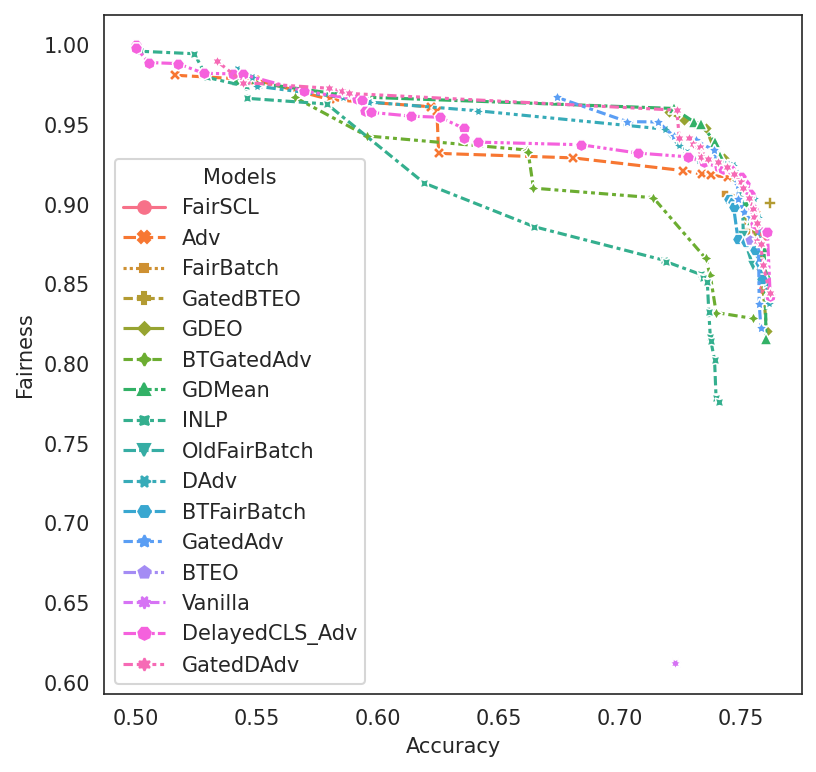

In [24]:
Moji_plot_df = analysis.final_results_df(
    results_dict = Moji_results,
    pareto = True,
    # pareto = False,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    # Performance_threshold=0.72
    # num_trail=20,
    )
make_plot(Moji_plot_df)

## Customized Datasets and Models

In [25]:
from fairlib import dataloaders

In [26]:
class CustomizedMojiDataset(dataloaders.utils.BaseDataset):

    p_aae = 0.5 # distribution of the main label, proportion of the AAE
    n = 12345 # target size

    def load_data(self):
        # stereotyping, 0.5 is balanced 
        if self.split == "train":
            self.ratio = 0.8 
        else:
            self.ratio = 0.5 # stereotyping, 0.5 is balanced 

        self.data_dir = Path(self.args.data_dir) / self.split

        n_1 = int(self.n * self.p_aae * self.ratio) # happy AAE 
        n_2 = int(self.n * (1-self.p_aae) * (1-self.ratio)) # happy SAE
        n_3 = int(self.n * self.p_aae * (1-self.ratio)) # unhappy AAE
        n_4 = int(self.n * (1-self.p_aae) * self.ratio) # unhappy SAE


        for file, label, protected, class_n in zip(['pos_pos', 'pos_neg', 'neg_pos', 'neg_neg'],
                                                                    [1, 1, 0, 0],
                                                                    [1, 0, 1, 0], 
                                                                    [n_1, n_2, n_3, n_4]
                                                                    ):
            data = np.load('{}/{}.npy'.format(self.data_dir, file))
            data = list(data[:class_n])
            self.X = self.X + data
            self.y = self.y + [label]*len(data)
            self.protected_label = self.protected_label + [protected]*len(data)

In [27]:
customized_dataset_args = {
    # "dataset":Shared_options["dataset"], 
    "dataset":"Customized", 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"customized_dataset",

    # Specify the hyperparameters for Balanced Training
    "BT":"Resampling",
    "BTObj":"EO",
}
customized_dataset_options = fairlib.BaseOptions()
customized_dataset_state = customized_dataset_options.get_state(args=customized_dataset_args, silence=True)

customized_train_data = CustomizedMojiDataset(args=customized_dataset_state, split="train")
customized_dev_data = CustomizedMojiDataset(args=customized_dataset_state, split="dev")
customized_test_data = CustomizedMojiDataset(args=customized_dataset_state, split="test")

# DataLoader Parameters
tran_dataloader_params = {
        'batch_size': customized_dataset_state.batch_size,
        'shuffle': True,
        'num_workers': customized_dataset_state.num_workers}

eval_dataloader_params = {
        'batch_size': customized_dataset_state.test_batch_size,
        'shuffle': False,
        'num_workers': customized_dataset_state.num_workers}

# init dataloader
customized_training_generator = torch.utils.data.DataLoader(customized_train_data, **tran_dataloader_params)
customized_validation_generator = torch.utils.data.DataLoader(customized_dev_data, **eval_dataloader_params)
customized_test_generator = torch.utils.data.DataLoader(customized_test_data, **eval_dataloader_params)

2022-04-28 11:19:36 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-525ea3e4-eabe-40ba-93be-e6b6a45add8f.json']
2022-04-28 11:19:36 [INFO ]  Logging to ./results/dev/Customized/customized_dataset/output.log
2022-04-28 11:19:36 [INFO ]  ======================================== 2022-04-28 11:19:36 ========================================
2022-04-28 11:19:36 [INFO ]  Base directory is ./results/dev/Customized/customized_dataset
Not implemented
2022-04-28 11:19:36 [INFO ]  dataloaders need to be initialized!
Loaded data shapes: (4936, 2304), (4936,), (4936,)
Loaded data shapes: (8000, 2304), (8000,), (8000,)
Loaded data shapes: (7996, 2304), (7996,), (7996,)


In [28]:
model_with_customized_dataset = fairlib.networks.get_main_model(customized_dataset_state)
model_with_customized_dataset.train_self(
    train_generator = customized_training_generator,
    dev_generator = customized_validation_generator,
    test_generator = customized_test_generator,
)

2022-04-28 11:19:37 [INFO ]  MLP( 
2022-04-28 11:19:37 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-04-28 11:19:37 [INFO ]    (AF): Tanh()
2022-04-28 11:19:37 [INFO ]    (hidden_layers): ModuleList(
2022-04-28 11:19:37 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-04-28 11:19:37 [INFO ]      (1): Tanh()
2022-04-28 11:19:37 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-04-28 11:19:37 [INFO ]      (3): Tanh()
2022-04-28 11:19:37 [INFO ]    )
2022-04-28 11:19:37 [INFO ]    (criterion): CrossEntropyLoss()
2022-04-28 11:19:37 [INFO ]  )
2022-04-28 11:19:37 [INFO ]  Total number of parameters: 782402 

2022-04-28 11:19:37 [INFO ]  Epoch:    0 [      0/   4936 ( 0%)]	Loss: 0.6932	 Data Time: 0.01s	Train Time: 0.07s
2022-04-28 11:19:38 [INFO ]  Evaluation at Epoch 0
2022-04-28 11:19:38 [INFO ]  Validation accuracy: 73.41	macro_fscore: 73.37	micro_fscore: 73.41	TPR_GAP: 16.23	FPR_GAP: 16.23	PPR_GA